# SetUp

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
def plot_image(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')
def plot_color_image(image):
    plt.imshow(image.astype(np.uint8), interpolation='nearest')
    plt.axis('off')

# Convolution layers

In [4]:
from sklearn.datasets import load_sample_image
china = load_sample_image('china.jpg')
flower = load_sample_image('flower.jpg')
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

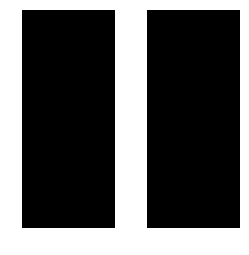

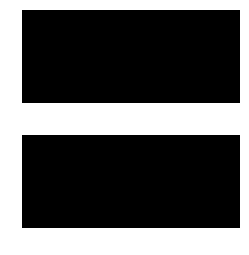

In [5]:
fmap = np.zeros(shape=(7,7,1,2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plot_image(fmap[:,:,0,0])
plt.show()
plot_image(fmap[:,:,0,1])
plt.show()

In [6]:
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

In [7]:
with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X:images})

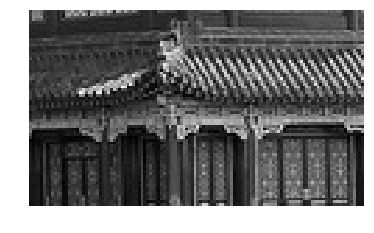

In [8]:
plot_image(images[0,:,:,0])
plt.show()

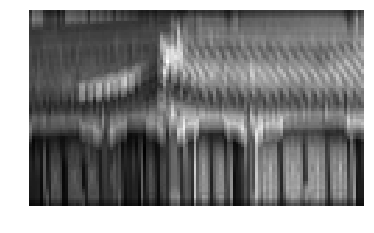

In [9]:
plot_image(output[0,:,:,0])
plt.show()

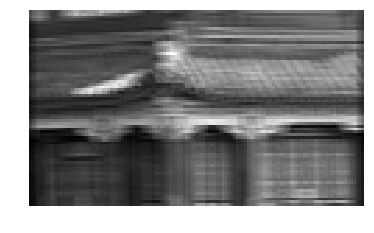

In [10]:
plot_image(output[0,:,:,1])
plt.show()

# Simple Example

In [11]:
china = load_sample_image('china.jpg')
flower = load_sample_image('flower.jpg')
dataset = np.array([china,flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7,7,channels,2), dtype=np.float32)
filters[:,3,:,0]=1
filters[3,:,:,1]=1

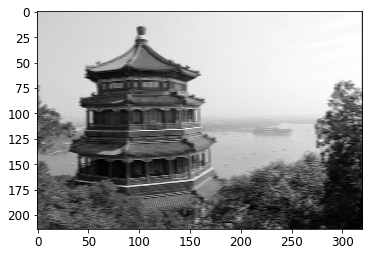

In [12]:
X = tf.placeholder(tf.float32, shape=(None,height,width,channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")
with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X:dataset})
plt.imshow(output[0,:,:,1], cmap="gray")
plt.show()

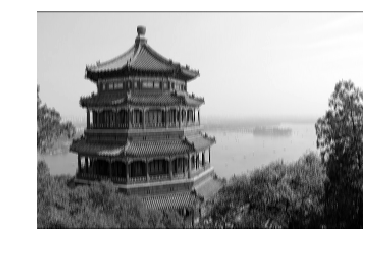

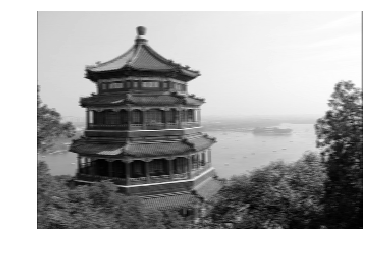

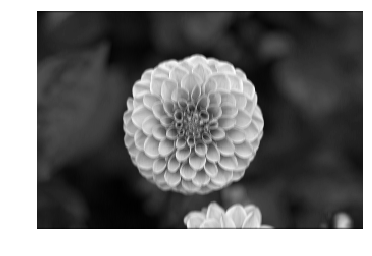

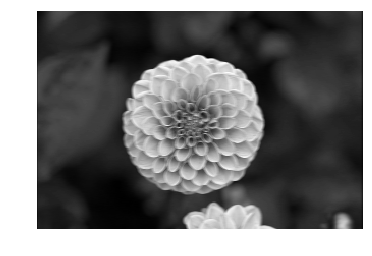

In [13]:
for image_index in (0,1):
    for feature_map_index in (0,1):
        plot_image(output[image_index,:,:, feature_map_index])
        plt.show()

In [14]:
reset_graph()
X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2], padding='SAME')

In [15]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X:dataset})

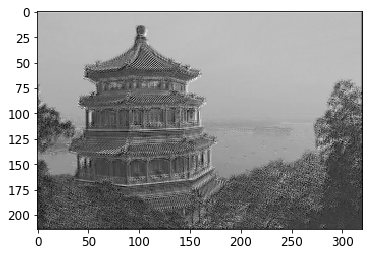

In [16]:
plt.imshow(output[0,:,:,1], cmap='gray')
plt.show()

# Pooling Layer

In [17]:
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

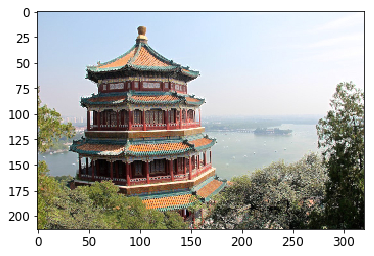

In [19]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X:dataset})
plt.imshow(output[0].astype(np.uint8))
plt.show()

# MNIST

In [22]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_padding = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_padding = "SAME"

pool3_fmap = conv2_fmaps

n_fc1 = 64
n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    X_reshaped = tf.reshape(X, shape=(-1, height, width, channels))
    y = tf.placeholder(tf.int32, shape=[None], name='y')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_padding,
                         activation=tf.nn.relu, name='conv1')

conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_padding,
                         activation=tf.nn.relu, name='conv2')

with tf.name_scope('pool3'):
    pool3 = tf.nn.max_pool(conv2, fc)
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmap*7*7])

with tf.name_scope('fc1'):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name='fc1')

with tf.name_scope('output'):
    logits = tf.layers.dense(fc1, n_outputs, name='output')
    Y_proba = tf.nn.softmax(logits, name='Y_proba')

with tf.name_scope('train'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope('init_and_save'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [24]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [ ]:
n_epochs = 10
batch_size = 100
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        acc_train = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        acc_test = accuracy.eval(feed_dict={X:mnaist.test.images, y:mnist.test.labels})
        print(epoch, "training accuracy", acc_train, "Test accuracy", acc_test)
        save_path = saver.save(sess, './my_mnist_model')

0 training accuracy 0.99 Test accuracy 0.9759
1 training accuracy 0.99 Test accuracy 0.9803
2 training accuracy 0.97 Test accuracy 0.9832
3 training accuracy 1.0 Test accuracy 0.9872
4 training accuracy 1.0 Test accuracy 0.9885
5 training accuracy 0.97 Test accuracy 0.9885
6 training accuracy 1.0 Test accuracy 0.9899
7 training accuracy 0.99 Test accuracy 0.989
8 training accuracy 1.0 Test accuracy 0.9881
